In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [2]:
import zipfile
import os

# Define the path of your zip file and the directory where you want to extract
zip_path = '/content/lfw.zip'
extract_to = '/content/'

# Create a ZipFile object
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to)

print("Files extracted successfully")

Files extracted successfully


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = './lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")


CUDA device is available. Using GPU: Tesla T4


torch.Size([250, 250, 3])


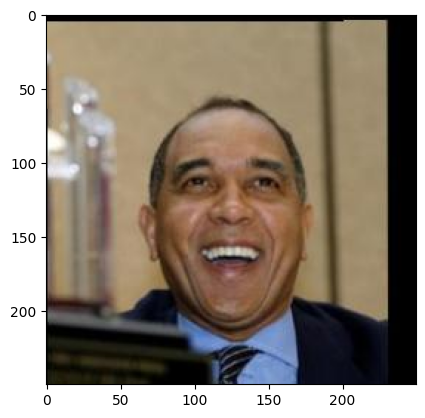

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [65]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Calculate the size of the flattened layer dynamically
        self._to_linear = None
        self._calculate_flat_size((3, 250, 250))  # This should be the size of your input images

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc21 = nn.Linear(1024, 20)
        self.fc22 = nn.Linear(1024, 20)

        # Decoder
        self.fc3 = nn.Linear(20, 1024)
        self.fc4 = nn.Linear(1024, 256*16*16)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def _calculate_flat_size(self, shape):
        with torch.no_grad():
            x = torch.ones(1, *shape)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            self._to_linear = x.view(-1).shape[0]

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 256, 16, 16) # Reshape for the transposed convolutional layers

        # Use transposed convolutions to upsample to the previous layer's spatial dimensions
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))

        # The output should match the input image size, which is [32, 3, 250, 250]
        # Adjust the kernel size, stride, and padding to get the desired output size
        z = self.deconv4(z)  # No need for activation here, as it will be applied after resizing

        # Resize to the correct output size if necessary
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)  # Apply sigmoid to scale the pixel values to [0, 1]
        return z


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [66]:
# Create an instance of VAE class
model = VAE().to(device)

# Assuming the dataloader has been defined and is loaded with images of the correct dimensions
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Pass an image through the model
with torch.no_grad():
    model.eval()
    mu, logvar = model.encode(images[0].unsqueeze(0))  # Corrected this line
    print("Shape of the encoder's output (mu):", mu.shape)
    print("Shape of the encoder's output (logvar):", logvar.shape)

    # Generate new samples in the latent space and decode them to create new images
    samples = model.reparameterize(mu, logvar)
    print("Shape of the samples in the latent space:", samples.shape)
    generated_images = model.decode(samples)
    print("Shape of the decoder's output (generated images):", generated_images.shape)

Shape of the encoder's output (mu): torch.Size([1, 20])
Shape of the encoder's output (logvar): torch.Size([1, 20])
Shape of the samples in the latent space: torch.Size([1, 20])
Shape of the decoder's output (generated images): torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [68]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 127,600,363 trainable parameters.


In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [70]:
# Training loop
# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    average_loss = train_loss / len(dataloader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {average_loss:.4f}')


# Sample and visualize images
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    # Visualize the generated images

Epoch: 1 [0/13237 (0%)]	Loss: 128821.078125
Epoch: 1 [320/13237 (2%)]	Loss: 128221.523438
Epoch: 1 [640/13237 (5%)]	Loss: 127812.796875
Epoch: 1 [960/13237 (7%)]	Loss: 127578.046875
Epoch: 1 [1280/13237 (10%)]	Loss: 127413.335938
Epoch: 1 [1600/13237 (12%)]	Loss: 122065.859375
Epoch: 1 [1920/13237 (14%)]	Loss: 117608.476562
Epoch: 1 [2240/13237 (17%)]	Loss: 119232.296875
Epoch: 1 [2560/13237 (19%)]	Loss: 115588.554688
Epoch: 1 [2880/13237 (22%)]	Loss: 115160.492188
Epoch: 1 [3200/13237 (24%)]	Loss: 112549.007812
Epoch: 1 [3520/13237 (27%)]	Loss: 116595.945312
Epoch: 1 [3840/13237 (29%)]	Loss: 111999.921875
Epoch: 1 [4160/13237 (31%)]	Loss: 108196.546875
Epoch: 1 [4480/13237 (34%)]	Loss: 111843.359375
Epoch: 1 [4800/13237 (36%)]	Loss: 109710.343750
Epoch: 1 [5120/13237 (39%)]	Loss: 110927.718750
Epoch: 1 [5440/13237 (41%)]	Loss: 105937.296875
Epoch: 1 [5760/13237 (43%)]	Loss: 111931.476562
Epoch: 1 [6080/13237 (46%)]	Loss: 109317.398438
Epoch: 1 [6400/13237 (48%)]	Loss: 110395.835938
Ep

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

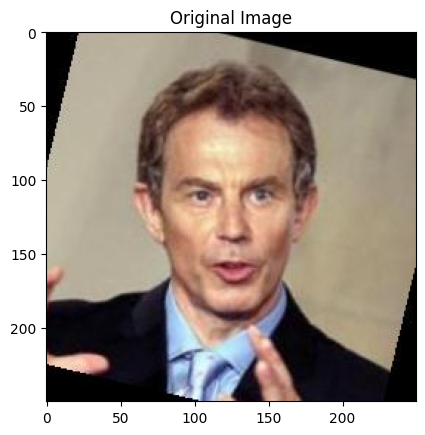

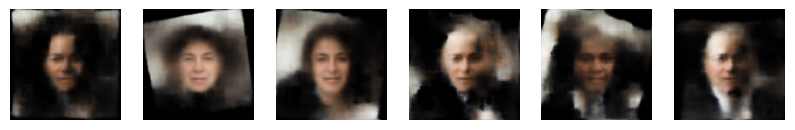

In [71]:
import matplotlib.pyplot as plt

# After training
model.eval()

# Take a random image from the dataset
with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader)):
            original_image = data[0].to(device)
            plt.imshow(original_image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.show()
            break

# Generate new samples and plot them
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    generated_images = model.decode(sample).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 2))
    for ax, img in zip(axes.flat, generated_images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.show()